# 微博话题#聚焦新冠肺炎疫情#

## 1. 数据抓取 

###  （1）hashtag.ipynb

In [4]:
#!/usr/bin/env python
# -*- coding: UTF-8 -*-

import codecs
import copy
import csv
import json
import math
import os
import random
import sys
import traceback
from collections import OrderedDict
from datetime import date, datetime, timedelta
from time import sleep

import requests
from lxml import etree
from requests.adapters import HTTPAdapter
from tqdm import tqdm


class Hashtag(object):
    def __init__(self, config):
        """Hashtag类初始化"""
        self.validate_config(config)
        self.filter = config[
            'filter']  # 取值范围为0、1,程序默认值为0,代表要爬取话题的全部微博,1代表只爬取话题的原创微博
        since_date = str(config['since_date'])
        if since_date.isdigit():
            since_date = str(date.today() - timedelta(int(since_date)))
        self.since_date = since_date  # 起始时间，即爬取发布日期从该值到现在的微博，形式为yyyy-mm-dd
        self.write_mode = config[
            'write_mode']  # 结果信息保存类型，为list形式，可包含csv、mongo和mysql三种类型
        self.original_pic_download = config[
            'original_pic_download']  # 取值范围为0、1, 0代表不下载原创微博图片,1代表下载
        self.retweet_pic_download = config[
            'retweet_pic_download']  # 取值范围为0、1, 0代表不下载转发微博图片,1代表下载
        self.original_video_download = config[
            'original_video_download']  # 取值范围为0、1, 0代表不下载原创微博视频,1代表下载
        self.retweet_video_download = config[
            'retweet_video_download']  # 取值范围为0、1, 0代表不下载转发微博视频,1代表下载
        self.cookie = {'Cookie': config.get('cookie')}  # 微博cookie，可填可不填
        self.mysql_config = config.get('mysql_config')  # MySQL数据库连接配置，可以不填

        # hashtag配置
        hashtag_list = config['hashtag_list']
        if not isinstance(hashtag_list, list):
            if not os.path.isabs(hashtag_list):
                hashtag_list = os.path.split(
                    os.path.realpath(__file__))[0] + os.sep + hashtag_list
            self.hashtag_config_file_path = hashtag_list  # 话题配置文件路径
            hashtag_config_list = self.get_hashtag_config_list(hashtag_list)
        else:
            self.hashtag_config_file_path = ''
            hashtag_config_list = [{
                'hashtag': hashtag,
                'since_date': self.since_date
            } for hashtag in hashtag_list]
        self.hashtag_config_list = hashtag_config_list  # 要爬取话题的hashtag_config列表
        self.hashtag_config = {}  # 话题配置,包含话题名称和since_date
        self.hashtag = {}  # 存储目标话题信息

        self.start_date = ''  # 获取话题第一条微博时的日期
        self.got_count = 0  # 存储爬取到的微博数
        self.weibo = []  # 存储爬取到的所有微博信息
        self.weibo_id_list = []  # 存储爬取到的所有微博id

    def validate_config(self, config):
        """验证配置是否正确"""

        # 验证filter、original_pic_download、retweet_pic_download、original_video_download、retweet_video_download
        argument_list = [
            'filter', 'original_pic_download', 'retweet_pic_download',
            'original_video_download', 'retweet_video_download'
        ]
        for argument in argument_list:
            if config[argument] != 0 and config[argument] != 1:
                sys.exit(u'%s值应为0或1,请重新输入' % config[argument])

        # 验证since_date
        since_date = str(config['since_date'])
        if (not self.is_date(since_date)) and (not since_date.isdigit()):
            sys.exit(u'since_date值应为yyyy-mm-dd形式或整数,请重新输入')

        # 验证write_mode
        write_mode = ['csv', 'json', 'mongo', 'mysql']
        if not isinstance(config['write_mode'], list):
            sys.exit(u'write_mode值应为list类型')
        for mode in config['write_mode']:
            if mode not in write_mode:
                sys.exit(
                    u'%s为无效模式，请从csv、json、mongo和mysql中挑选一个或多个作为write_mode' %
                    mode)

        # 验证hashtag_list
        hashtag_list = config['hashtag_list']
        if (not isinstance(hashtag_list, list)) and (not hashtag_list.endswith('.txt')):
            sys.exit(u'hashtag_list值应为list类型或txt文件路径')
        if not isinstance(hashtag_list, list):
            if not os.path.isabs(hashtag_list):
                hashtag_list = os.path.split(
                    os.path.realpath(__file__))[0] + os.sep + hashtag_list
            if not os.path.isfile(hashtag_list):
                sys.exit(u'不存在%s文件' % hashtag_list)

    def is_date(self, since_date):
        """判断日期格式是否正确"""
        try:
            datetime.strptime(since_date, "%Y-%m-%d")
            return True
        except ValueError:
            return False

    def get_json(self, params):
        """获取网页中json数据"""
        url = 'https://m.weibo.cn/api/container/getIndex?'
        r = requests.get(url, params=params, cookies=self.cookie)
        return r.json()

    def get_hashtag_json(self, page):
        """获取话题搜索结果"""
        params = {
            'containerid': '100103type=1&q=' + self.hashtag_config['hashtag'],
            'page_type': 'searchall',
            'page': page
        }
        js = self.get_json(params)
        return js

    def get_long_weibo(self, id):
        """获取长微博"""
        for i in range(5):
            url = 'https://m.weibo.cn/detail/%s' % id
            html = requests.get(url, cookies=self.cookie).text
            html = html[html.find('"status":'):]
            html = html[:html.rfind('"hotScheme"')]
            html = html[:html.rfind(',')]
            html = '{' + html + '}'
            js = json.loads(html, strict=False)
            weibo_info = js.get('status')
            if weibo_info:
                weibo = self.parse_weibo(weibo_info)
                return weibo
            sleep(random.randint(6, 10))

    def get_pics(self, weibo_info):
        """获取微博原始图片url"""
        if weibo_info.get('pics'):
            pic_info = weibo_info['pics']
            pic_list = [pic['large']['url'] for pic in pic_info]
            pics = ','.join(pic_list)
        else:
            pics = ''
        return pics

    def get_live_photo(self, weibo_info):
        """获取live photo中的视频url"""
        live_photo_list = []
        live_photo = weibo_info.get('pic_video')
        if live_photo:
            prefix = 'https://video.weibo.com/media/play?livephoto=//us.sinaimg.cn/'
            for i in live_photo.split(','):
                if len(i.split(':')) == 2:
                    url = prefix + i.split(':')[1] + '.mov'
                    live_photo_list.append(url)
            return live_photo_list

    def get_video_url(self, weibo_info):
        """获取微博视频url"""
        video_url = ''
        video_url_list = []
        if weibo_info.get('page_info'):
            if weibo_info['page_info'].get('media_info') and weibo_info[
                'page_info'].get('type') == 'video':
                media_info = weibo_info['page_info']['media_info']
                video_url = media_info.get('mp4_720p_mp4')
                if not video_url:
                    video_url = media_info.get('mp4_hd_url')
                    if not video_url:
                        video_url = media_info.get('mp4_sd_url')
                        if not video_url:
                            video_url = media_info.get('stream_url_hd')
                            if not video_url:
                                video_url = media_info.get('stream_url')
        if video_url:
            video_url_list.append(video_url)
        live_photo_list = self.get_live_photo(weibo_info)
        if live_photo_list:
            video_url_list += live_photo_list
        return ';'.join(video_url_list)

    def download_one_file(self, url, file_path, type, weibo_id):
        """下载单个文件(图片/视频)"""
        try:
            if not os.path.isfile(file_path):
                s = requests.Session()
                s.mount(url, HTTPAdapter(max_retries=5))
                downloaded = s.get(url, cookies=self.cookie, timeout=(5, 10))
                with open(file_path, 'wb') as f:
                    f.write(downloaded.content)
        except Exception as e:
            error_file = self.get_filepath(
                type) + os.sep + 'not_downloaded.txt'
            with open(error_file, 'ab') as f:
                url = str(weibo_id) + ':' + url + '\n'
                f.write(url.encode(sys.stdout.encoding))
            print('Error: ', e)
            traceback.print_exc()

    def handle_download(self, file_type, file_dir, urls, w):
        """处理下载相关操作"""
        file_prefix = w['created_at'][:11].replace('-', '') + '_' + str(
            w['id'])
        if file_type == 'img':
            if ',' in urls:
                url_list = urls.split(',')
                for i, url in enumerate(url_list):
                    index = url.rfind('.')
                    if len(url) - index >= 5:
                        file_suffix = '.jpg'
                    else:
                        file_suffix = url[index:]
                    file_name = file_prefix + '_' + str(i + 1) + file_suffix
                    file_path = file_dir + os.sep + file_name
                    self.download_one_file(url, file_path, file_type, w['id'])
            else:
                index = urls.rfind('.')
                if len(urls) - index > 5:
                    file_suffix = '.jpg'
                else:
                    file_suffix = urls[index:]
                file_name = file_prefix + file_suffix
                file_path = file_dir + os.sep + file_name
                self.download_one_file(urls, file_path, file_type, w['id'])
        else:
            file_suffix = '.mp4'
            if ';' in urls:
                url_list = urls.split(';')
                if url_list[0].endswith('.mov'):
                    file_suffix = '.mov'
                for i, url in enumerate(url_list):
                    file_name = file_prefix + '_' + str(i + 1) + file_suffix
                    file_path = file_dir + os.sep + file_name
                    self.download_one_file(url, file_path, file_type, w['id'])
            else:
                if urls.endswith('.mov'):
                    file_suffix = '.mov'
                file_name = file_prefix + file_suffix
                file_path = file_dir + os.sep + file_name
                self.download_one_file(urls, file_path, file_type, w['id'])

    def download_files(self, file_type, weibo_type, wrote_count):
        """下载文件(图片/视频)"""
        try:
            describe = ''
            if file_type == 'img':
                describe = u'图片'
                key = 'pics'
            else:
                describe = u'视频'
                key = 'video_url'
            if weibo_type == 'original':
                describe = u'原创微博' + describe
            else:
                describe = u'转发微博' + describe
            print(u'即将进行%s下载' % describe)
            file_dir = self.get_filepath(file_type)
            file_dir = file_dir + os.sep + describe
            if not os.path.isdir(file_dir):
                os.makedirs(file_dir)
            for w in tqdm(self.weibo[wrote_count:], desc='Download progress'):
                if weibo_type == 'retweet':
                    if w.get('retweet'):
                        w = w['retweet']
                    else:
                        continue
                if w.get(key):
                    self.handle_download(file_type, file_dir, w.get(key), w)
            print(u'%s下载完毕,保存路径:' % describe)
            print(file_dir)
        except Exception as e:
            print('Error: ', e)
            traceback.print_exc()

    def get_location(self, selector):
        """获取微博发布位置"""
        location_icon = 'timeline_card_small_location_default.png'
        span_list = selector.xpath('//span')
        location = ''
        for i, span in enumerate(span_list):
            if span.xpath('img/@src'):
                if location_icon in span.xpath('img/@src')[0]:
                    location = span_list[i + 1].xpath('string(.)')
                    break
        return location

    def get_article_url(self, selector):
        """获取微博中头条文章的url"""
        article_url = ''
        text = selector.xpath('string(.)')
        if text.startswith(u'发布了头条文章'):
            url = selector.xpath('//a/@data-url')
            if url and url[0].startswith('http://t.cn'):
                article_url = url[0]
        return article_url

    def get_topics(self, selector):
        """获取参与的微博话题"""
        span_list = selector.xpath("//span[@class='surl-text']")
        topics = ''
        topic_list = []
        for span in span_list:
            text = span.xpath('string(.)')
            if len(text) > 2 and text[0] == '#' and text[-1] == '#':
                topic_list.append(text[1:-1])
        if topic_list:
            topics = ','.join(topic_list)
        return topics

    def get_at_users(self, selector):
        """获取@用户"""
        a_list = selector.xpath('//a')
        at_users = ''
        at_list = []
        for a in a_list:
            if '@' + a.xpath('@href')[0][3:] == a.xpath('string(.)'):
                at_list.append(a.xpath('string(.)')[1:])
        if at_list:
            at_users = ','.join(at_list)
        return at_users

    def string_to_int(self, string):
        """字符串转换为整数"""
        if isinstance(string, int):
            return string
        elif string.endswith(u'万+'):
            string = int(string[:-2] + '0000')
        elif string.endswith(u'万'):
            string = int(string[:-1] + '0000')
        return int(string)

    def standardize_date(self, created_at):
        """标准化微博发布时间"""
        if u"刚刚" in created_at:
            created_at = datetime.now().strftime("%Y-%m-%d")
        elif u"分钟" in created_at:
            minute = created_at[:created_at.find(u"分钟")]
            minute = timedelta(minutes=int(minute))
            created_at = (datetime.now() - minute).strftime("%Y-%m-%d")
        elif u"小时" in created_at:
            hour = created_at[:created_at.find(u"小时")]
            hour = timedelta(hours=int(hour))
            created_at = (datetime.now() - hour).strftime("%Y-%m-%d")
        elif u"昨天" in created_at:
            day = timedelta(days=1)
            created_at = (datetime.now() - day).strftime("%Y-%m-%d")
        elif created_at.count('-') == 1:
            year = datetime.now().strftime("%Y")
            created_at = year + "-" + created_at
        return created_at

    def standardize_info(self, weibo):
        """标准化信息，去除乱码"""
        for k, v in weibo.items():
            if 'bool' not in str(type(v)) and 'int' not in str(
                    type(v)) and 'list' not in str(
                type(v)) and 'long' not in str(type(v)):
                weibo[k] = v.replace(u"\u200b", "").encode(
                    sys.stdout.encoding, "ignore").decode(sys.stdout.encoding)
        return weibo

    def parse_weibo(self, weibo_info):
        weibo = OrderedDict()
        if weibo_info['user']:
            weibo['user_id'] = weibo_info['user']['id']
            weibo['screen_name'] = weibo_info['user']['screen_name']
        else:
            weibo['user_id'] = ''
            weibo['screen_name'] = ''
        weibo['id'] = int(weibo_info['id'])
        weibo['bid'] = weibo_info['bid']
        text_body = weibo_info['text']
        selector = etree.HTML(text_body)
        weibo['text'] = etree.HTML(text_body).xpath('string(.)')
        weibo['article_url'] = self.get_article_url(selector)
        weibo['pics'] = self.get_pics(weibo_info)
        weibo['video_url'] = self.get_video_url(weibo_info)
        weibo['location'] = self.get_location(selector)
        weibo['created_at'] = weibo_info['created_at']
        weibo['source'] = weibo_info['source']
        weibo['attitudes_count'] = self.string_to_int(
            weibo_info.get('attitudes_count', 0))
        weibo['comments_count'] = self.string_to_int(
            weibo_info.get('comments_count', 0))
        weibo['reposts_count'] = self.string_to_int(
            weibo_info.get('reposts_count', 0))
        weibo['topics'] = self.get_topics(selector)
        weibo['at_users'] = self.get_at_users(selector)
        return self.standardize_info(weibo)

    def print_hashtag_info(self):
        """打印话题信息"""
        print('+' * 100)
        print(u'话题：%s' % self.hashtag['name'])
        print('+' * 100)

    def print_one_weibo(self, weibo):
        """打印一条微博"""
        try:
            print(u'微博id：%d' % weibo['id'])
            print(u'微博正文：%s' % weibo['text'])
            print(u'原始图片url：%s' % weibo['pics'])
            print(u'微博位置：%s' % weibo['location'])
            print(u'发布时间：%s' % weibo['created_at'])
            print(u'发布工具：%s' % weibo['source'])
            print(u'点赞数：%d' % weibo['attitudes_count'])
            print(u'评论数：%d' % weibo['comments_count'])
            print(u'转发数：%d' % weibo['reposts_count'])
            print(u'话题：%s' % weibo['topics'])
            print(u'@用户：%s' % weibo['at_users'])
            print(u'url：https://m.weibo.cn/detail/%d' % weibo['id'])
        except OSError:
            pass

    def print_weibo(self, weibo):
        """打印微博，若为转发微博，会同时打印原创和转发部分"""
        if weibo.get('retweet'):
            print('*' * 100)
            print(u'转发部分：')
            self.print_one_weibo(weibo['retweet'])
            print('*' * 100)
            print(u'原创部分：')
        self.print_one_weibo(weibo)
        print('-' * 120)

    def get_one_weibo(self, info):
        """获取一条微博的全部信息"""
        try:
            weibo_info = info['mblog']
            weibo_id = weibo_info['id']
            retweeted_status = weibo_info.get('retweeted_status')
            is_long = weibo_info.get('isLongText')
            if retweeted_status and retweeted_status.get('id'):  # 转发
                retweet_id = retweeted_status.get('id')
                is_long_retweet = retweeted_status.get('isLongText')
                if is_long:
                    weibo = self.get_long_weibo(weibo_id)
                    if not weibo:
                        weibo = self.parse_weibo(weibo_info)
                else:
                    weibo = self.parse_weibo(weibo_info)
                if is_long_retweet:
                    retweet = self.get_long_weibo(retweet_id)
                    if not retweet:
                        retweet = self.parse_weibo(retweeted_status)
                else:
                    retweet = self.parse_weibo(retweeted_status)
                retweet['created_at'] = self.standardize_date(
                    retweeted_status['created_at'])
                weibo['retweet'] = retweet
            else:  # 原创
                if is_long:
                    weibo = self.get_long_weibo(weibo_id)
                    if not weibo:
                        weibo = self.parse_weibo(weibo_info)
                else:
                    weibo = self.parse_weibo(weibo_info)
            weibo['created_at'] = self.standardize_date(
                weibo_info['created_at'])
            return weibo
        except Exception as e:
            print("Error: ", e)
            traceback.print_exc()

    def is_pinned_weibo(self, info):
        """判断微博是否为置顶微博"""
        weibo_info = info['mblog']
        title = weibo_info.get('title')
        if title and title.get('text') == u'置顶':
            return True
        else:
            return False

    def get_one_page(self, page):
        """获取一页的全部微博"""
        try:
            js = self.get_hashtag_json(page)
            if js['ok']:
                weibos = js['data']['cards']
                for w in weibos:
                    if w['card_type'] == 9:
                        wb = self.get_one_weibo(w)
                        if wb:
                            if wb['id'] in self.weibo_id_list:
                                continue
                            created_at = datetime.strptime(
                                wb['created_at'], '%Y-%m-%d')
                            since_date = datetime.strptime(
                                self.hashtag_config['since_date'], '%Y-%m-%d')
                            if created_at < since_date:
                                if self.is_pinned_weibo(w):
                                    continue
                                else:
                                    print(u'{}已获取{}的第{}页微博{}'.format(
                                        '-' * 30, self.hashtag['name'], page, '-' * 30))
                                    return True
                            if (not self.filter) or (
                                    'retweet' not in wb.keys()):
                                self.weibo.append(wb)
                                self.weibo_id_list.append(wb['id'])
                                self.got_count += 1
                                self.print_weibo(wb)
                            else:
                                print(u'正在过滤转发微博')
            print(u'{}已获取{}的第{}页微博{}'.format('-' * 30, self.hashtag['name'], page, '-' * 30))
        except Exception as e:
            print("Error: ", e)
            traceback.print_exc()

    def get_page_count(self):
        """获取微博页数"""
        try:
            weibo_count = self.hashtag['statuses_count']
            page_count = int(math.ceil(weibo_count / 10.0))
            return page_count
        except KeyError:
            print(u'程序出错，错误原因可能为：\n'
                  u'此话题微博可能需要设置cookie才能爬取。\n'
                  u'解决方案：\n'
                  u'请参考\n'
                  u'https://github.com/dataabc/weibo-crawler#3程序设置\n'
                  u'中的“设置cookie”部分设置cookie信息')

    def get_write_info(self, wrote_count):
        """获取要写入的微博信息"""
        write_info = []
        for w in self.weibo[wrote_count:]:
            wb = OrderedDict()
            for k, v in w.items():
                if k not in ['user_id', 'screen_name', 'retweet']:
                    if 'unicode' in str(type(v)):
                        v = v.encode('utf-8')
                    wb[k] = v
            if not self.filter:
                if w.get('retweet'):
                    wb['is_original'] = False
                    for k2, v2 in w['retweet'].items():
                        if 'unicode' in str(type(v2)):
                            v2 = v2.encode('utf-8')
                        wb['retweet_' + k2] = v2
                else:
                    wb['is_original'] = True
            write_info.append(wb)
        return write_info

    def get_filepath(self, type):
        """获取结果文件路径"""
        try:
            file_dir = os.path.split(
                os.path.realpath(__file__)
            )[0] + os.sep + 'weibo' + os.sep + self.hashtag['name']
            if type == 'img' or type == 'video':
                file_dir = file_dir + os.sep + type
            if not os.path.isdir(file_dir):
                os.makedirs(file_dir)
            if type == 'img' or type == 'video':
                return file_dir
            file_path = file_dir + os.sep + self.hashtag_config[
                'hashtag'] + '.' + type
            return file_path
        except Exception as e:
            print('Error: ', e)
            traceback.print_exc()

    def get_result_headers(self):
        """获取要写入结果文件的表头"""
        result_headers = [
            'id', 'bid', '正文', '头条文章url', '原始图片url', '视频url', '位置', '日期', '工具',
            '点赞数', '评论数', '转发数', '话题', '@用户'
        ]
        if not self.filter:
            result_headers2 = ['是否原创', '源用户id', '源用户昵称']
            result_headers3 = ['源微博' + r for r in result_headers]
            result_headers = result_headers + result_headers2 + result_headers3
        return result_headers

    def write_csv(self, wrote_count):
        """将爬到的信息写入csv文件"""
        write_info = self.get_write_info(wrote_count)
        result_headers = self.get_result_headers()
        result_data = [w.values() for w in write_info]
        print(result_data[0])
        file_path = self.get_filepath('csv')
        self.csv_helper(result_headers, result_data, file_path)

    def csv_helper(self, headers, result_data, file_path):
        """将指定信息写入csv文件"""
        if not os.path.isfile(file_path):
            is_first_write = 1
        else:
            is_first_write = 0
        if sys.version < '3':  # python2.x
            with open(file_path, 'ab') as f:
                f.write(codecs.BOM_UTF8)
                writer = csv.writer(f)
                if is_first_write:
                    writer.writerows([headers])
                writer.writerows(result_data)
        else:  # python3.x
            with open(file_path, 'a', encoding='utf-8-sig', newline='') as f:
                writer = csv.writer(f)
                if is_first_write:
                    writer.writerows([headers])
                writer.writerows(result_data)
        if headers[0] == 'id':
            print(u'%d条微博写入csv文件完毕,保存路径:' % self.got_count)
        else:
            print(u'%s 信息写入csv文件完毕，保存路径:' % self.hashtag['name'])
        print(file_path)

    def update_json_data(self, data, weibo_info):
        """更新要写入json结果文件中的数据，已经存在于json中的信息更新为最新值，不存在的信息添加到data中"""
        data['hashtag'] = self.hashtag
        if data.get('weibo'):
            is_new = 1  # 待写入微博是否全部为新微博，即待写入微博与json中的数据不重复
            for old in data['weibo']:
                if weibo_info[-1]['id'] == old['id']:
                    is_new = 0
                    break
            if is_new == 0:
                for new in weibo_info:
                    flag = 1
                    for i, old in enumerate(data['weibo']):
                        if new['id'] == old['id']:
                            data['weibo'][i] = new
                            flag = 0
                            break
                    if flag:
                        data['weibo'].append(new)
            else:
                data['weibo'] += weibo_info
        else:
            data['weibo'] = weibo_info
        return data

    def write_json(self, wrote_count):
        """将爬到的信息写入json文件"""
        data = {}
        path = self.get_filepath('json')
        if os.path.isfile(path):
            with codecs.open(path, 'r', encoding="utf-8") as f:
                data = json.load(f)
        weibo_info = self.weibo[wrote_count:]
        data = self.update_json_data(data, weibo_info)
        with codecs.open(path, 'w', encoding="utf-8") as f:
            json.dump(data, f, ensure_ascii=False)
        print(u'%d条微博写入json文件完毕,保存路径:' % self.got_count)
        print(path)

    def info_to_mongodb(self, collection, info_list):
        """将爬取的信息写入MongoDB数据库"""
        try:
            import pymongo
        except ImportError:
            sys.exit(u'系统中可能没有安装pymongo库，请先运行 pip install pymongo ，再运行程序')
        try:
            from pymongo import MongoClient

            client = MongoClient()
            db = client['weibo']
            collection = db[collection]
            if len(self.write_mode) > 1:
                new_info_list = copy.deepcopy(info_list)
            else:
                new_info_list = info_list
            for info in new_info_list:
                if not collection.find_one({'id': info['id']}):
                    collection.insert_one(info)
                else:
                    collection.update_one({'id': info['id']}, {'$set': info})
        except pymongo.errors.ServerSelectionTimeoutError:
            sys.exit(u'系统中可能没有安装或启动MongoDB数据库，请先根据系统环境安装或启动MongoDB，再运行程序')

    def weibo_to_mongodb(self, wrote_count):
        """将爬取的微博信息写入MongoDB数据库"""
        self.info_to_mongodb('weibo', self.weibo[wrote_count:])
        print(u'%d条微博写入MongoDB数据库完毕' % self.got_count)

    def mysql_create(self, connection, sql):
        """创建MySQL数据库或表"""
        try:
            with connection.cursor() as cursor:
                cursor.execute(sql)
        finally:
            connection.close()

    def mysql_create_database(self, mysql_config, sql):
        """创建MySQL数据库"""
        try:
            import pymysql
        except ImportError:
            sys.exit(u'系统中可能没有安装pymysql库，请先运行 pip install pymysql ，再运行程序')
        try:
            if self.mysql_config:
                mysql_config = self.mysql_config
            connection = pymysql.connect(**mysql_config)
            self.mysql_create(connection, sql)
        except pymysql.OperationalError:
            sys.exit(u'系统中可能没有安装或正确配置MySQL数据库，请先根据系统环境安装或配置MySQL，再运行程序')

    def mysql_create_table(self, mysql_config, sql):
        """创建MySQL表"""
        import pymysql

        if self.mysql_config:
            mysql_config = self.mysql_config
        mysql_config['db'] = 'weibo'
        connection = pymysql.connect(**mysql_config)
        self.mysql_create(connection, sql)

    def mysql_insert(self, mysql_config, table, data_list):
        """向MySQL表插入或更新数据"""
        import pymysql

        if len(data_list) > 0:
            keys = ', '.join(data_list[0].keys())
            values = ', '.join(['%s'] * len(data_list[0]))
            if self.mysql_config:
                mysql_config = self.mysql_config
            mysql_config['db'] = 'weibo'
            connection = pymysql.connect(**mysql_config)
            cursor = connection.cursor()
            sql = """INSERT INTO {table}({keys}) VALUES ({values}) ON
                     DUPLICATE KEY UPDATE""".format(table=table,
                                                    keys=keys,
                                                    values=values)
            update = ','.join([
                " {key} = values({key})".format(key=key)
                for key in data_list[0]
            ])
            sql += update
            try:
                cursor.executemany(
                    sql, [tuple(data.values()) for data in data_list])
                connection.commit()
            except Exception as e:
                connection.rollback()
                print('Error: ', e)
                traceback.print_exc()
            finally:
                connection.close()

    def weibo_to_mysql(self, wrote_count):
        """将爬取的微博信息写入MySQL数据库"""
        mysql_config = {
            'host': 'localhost',
            'port': 3306,
            'user': 'root',
            'password': '123456',
            'charset': 'utf8mb4'
        }
        # 创建'weibo'表
        create_table = """
                CREATE TABLE IF NOT EXISTS weibo (
                id varchar(20) NOT NULL,
                bid varchar(12) NOT NULL,
                user_id varchar(20),
                screen_name varchar(30),
                text varchar(2000),
                article_url varchar(100),
                topics varchar(200),
                at_users varchar(1000),
                pics varchar(3000),
                video_url varchar(1000),
                location varchar(100),
                created_at DATETIME,
                source varchar(30),
                attitudes_count INT,
                comments_count INT,
                reposts_count INT,
                retweet_id varchar(20),
                PRIMARY KEY (id)
                ) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4"""
        self.mysql_create_table(mysql_config, create_table)
        weibo_list = []
        retweet_list = []
        if len(self.write_mode) > 1:
            info_list = copy.deepcopy(self.weibo[wrote_count:])
        else:
            info_list = self.weibo[wrote_count:]
        for w in info_list:
            if 'retweet' in w:
                w['retweet']['retweet_id'] = ''
                retweet_list.append(w['retweet'])
                w['retweet_id'] = w['retweet']['id']
                del w['retweet']
            else:
                w['retweet_id'] = ''
            weibo_list.append(w)
        # 在'weibo'表中插入或更新微博数据
        self.mysql_insert(mysql_config, 'weibo', retweet_list)
        self.mysql_insert(mysql_config, 'weibo', weibo_list)
        print(u'%d条微博写入MySQL数据库完毕' % self.got_count)

    def update_hashtag_config_file(self, hashtag_config_file_path):
        """更新话题配置文件"""
        with open(hashtag_config_file_path, 'rb') as f:
            try:
                lines = f.read().splitlines()
                lines = [line.decode('utf-8-sig') for line in lines]
            except UnicodeDecodeError:
                sys.exit(u'%s文件应为utf-8编码，请先将文件编码转为utf-8再运行程序' %
                         hashtag_config_file_path)
            for i, line in enumerate(lines):
                info = line.split(' ')
                if len(info) > 0:
                    if self.hashtag_config['hashtag'] == info[0]:
                        if len(info) == 1:
                            info.append(self.start_date)
                        if len(info) > 1:
                            info[1] = self.start_date
                        lines[i] = ' '.join(info)
                        break
        with codecs.open(hashtag_config_file_path, 'w', encoding='utf-8') as f:
            f.write('\n'.join(lines))

    def write_data(self, wrote_count):
        """将爬到的信息写入文件或数据库"""
        if self.got_count > wrote_count:
            if 'csv' in self.write_mode:
                self.write_csv(wrote_count)
            if 'json' in self.write_mode:
                self.write_json(wrote_count)
            if 'mysql' in self.write_mode:
                self.weibo_to_mysql(wrote_count)
            if 'mongo' in self.write_mode:
                self.weibo_to_mongodb(wrote_count)
            if self.original_pic_download:
                self.download_files('img', 'original', wrote_count)
            if self.original_video_download:
                self.download_files('video', 'original', wrote_count)
            if not self.filter:
                if self.retweet_pic_download:
                    self.download_files('img', 'retweet', wrote_count)
                if self.retweet_video_download:
                    self.download_files('video', 'retweet', wrote_count)

    def get_pages(self):
        """获取全部微博"""
        try:
            self.hashtag['name'] = self.hashtag_config['hashtag']
            js = self.get_hashtag_json(1)
            self.hashtag['statuses_count'] = js['data']['cardlistInfo']['total']
            self.print_hashtag_info()
            since_date = datetime.strptime(self.hashtag_config['since_date'], '%Y-%m-%d')
            today = datetime.strptime(str(date.today()), '%Y-%m-%d')
            if since_date <= today:
                page_count = self.get_page_count()
                wrote_count = 0
                page1 = 0
                random_pages = random.randint(1, 5)
                self.start_date = datetime.now().strftime('%Y-%m-%d')
                for page in tqdm(range(1, page_count + 1), desc='Progress'):
                    is_end = self.get_one_page(page)
                    if is_end:
                        break
                    if page % 20 == 0:  # 每爬20页写入一次文件
                        self.write_data(wrote_count)
                        wrote_count = self.got_count

                    # 通过加入随机等待避免被限制。爬虫速度过快容易被系统限制(一段时间后限
                    # 制会自动解除)，加入随机等待模拟人的操作，可降低被系统限制的风险。默
                    # 认是每爬取1到5页随机等待6到10秒，如果仍然被限，可适当增加sleep时间
                    if (page -
                        page1) % random_pages == 0 and page < page_count:
                        sleep(random.randint(6, 10))
                        page1 = page
                        random_pages = random.randint(1, 5)
                self.write_data(wrote_count)  # 将剩余不足20页的微博写入文件
            print(u'微博爬取完成，共爬取%d条微博' % self.got_count)
        except Exception as e:
            print("Error: ", e)
            traceback.print_exc()

    def get_hashtag_config_list(self, file_path):
        """获取文件中的hashtag信息"""
        with open(file_path, 'rb') as f:
            try:
                lines = f.read().splitlines()
                lines = [line.decode('utf-8-sig') for line in lines]
            except UnicodeDecodeError:
                sys.exit(u'%s文件应为utf-8编码，请先将文件编码转为utf-8再运行程序' % file_path)
            hashtag_config_list = []
            for line in lines:
                info = line.split(' ')
                if len(info) > 0:
                    hashtag_config = {'hashtag': info[0]}
                    if len(info) > 1 and self.is_date(info[1]):
                        hashtag_config['since_date'] = info[1]
                    else:
                        hashtag_config['since_date'] = self.since_date
                    if hashtag_config not in hashtag_config_list:
                        hashtag_config_list.append(hashtag_config)
        return hashtag_config_list

    def initialize_info(self, hashtag_config):
        """初始化hashtag爬虫信息"""
        self.weibo = []
        self.hashtag = {}
        self.hashtag_config = hashtag_config
        self.got_count = 0
        self.weibo_id_list = []

    def start(self):
        """运行爬虫"""
        try:
            for hashtag_config in self.hashtag_config_list:
                self.initialize_info(hashtag_config)
                self.get_pages()
                print(u'信息抓取完毕')
                print('*' * 100)
                if self.hashtag_config_file_path:
                    self.update_hashtag_config_file(self.hashtag_config_file_path)
        except Exception as e:
            print('Error: ', e)
            traceback.print_exc()


def get_config():
    """获取config.json文件信息"""
    config_path = os.path.split(
        os.path.realpath(__file__))[0] + os.sep + 'config.json'
    if not os.path.isfile(config_path):
        sys.exit(u'当前路径：%s 不存在配置文件config.json' %
                 (os.path.split(os.path.realpath(__file__))[0] + os.sep))
    try:
        with open(config_path,encoding='utf-8') as f:
            config = json.loads(f.read())
            return config
    except ValueError:
        sys.exit(u'config.json 格式不正确，请参考 '
                 u'https://github.com/dataabc/weibo-crawler#3程序设置')


def main():
    try:
        config = get_config()
        ht = Hashtag(config)
        ht.start()  # 爬取微博信息
    except Exception as e:
        print('Error: ', e)
        traceback.print_exc()


if __name__ == '__main__':
    main()

Error:  name '__file__' is not defined


Traceback (most recent call last):
  File "<ipython-input-4-bf672738d7f2>", line 948, in main
    config = get_config()
  File "<ipython-input-4-bf672738d7f2>", line 933, in get_config
    os.path.realpath(__file__))[0] + os.sep + 'config.json'
NameError: name '__file__' is not defined


### （2）config.json

In [1]:
{
  "hashtag_list": ["#聚焦新冠肺炎疫情#"],
  "filter": 1,
  "since_date": "2020-11-18",
  "write_mode": ["csv"],
  "original_pic_download": 0,
  "retweet_pic_download": 0,
  "original_video_download": 0,
  "retweet_video_download": 0,
  "cookie": "your cookie",
  "mysql_config": {
    "host": "localhost",
    "port": 3306,
    "user": "root",
    "password": "123456",
    "charset": "utf8mb4"
  }
}


{'hashtag_list': ['#聚焦新冠肺炎疫情#'],
 'filter': 1,
 'since_date': '2020-11-18',
 'write_mode': ['csv'],
 'original_pic_download': 0,
 'retweet_pic_download': 0,
 'original_video_download': 0,
 'retweet_video_download': 0,
 'cookie': 'your cookie',
 'mysql_config': {'host': 'localhost',
  'port': 3306,
  'user': 'root',
  'password': '123456',
  'charset': 'utf8mb4'}}

### （3）运行代码

%run hashtag.ipynb

In [2]:
# 获得文件#聚焦新冠肺炎疫情#.csv（为便于数据处理，修改文件名及格式为 hashtag.xlsx）

### （4）读取文件

In [9]:
import pandas as pd
import numpy as np

# 读取文件 hashtag.xlsx
data=pd.read_excel(r'D:\python作业\pythonProject\hashtag.xlsx',encoding="utf-8")
data

,id,bid,正文,头条文章url,原始图片url,视频url,位置,日期,工具,点赞数,评论数,转发数,传播效果,@用户
0,4580682615756170,JxQVfo9ry,【河北沧州献县发布通告：要求全县冷链物品装卸工人进行核酸检测】12月10日，河北沧州献县新冠...,NaN,NaN,http://f.video.weibocdn.com/u41he95klx07IFAJC7...,NaN,2021-12-10 00:00:00,微博云剪,42,19,12,73,无
1,4580973523510250,JxYuseJaZ,谁设计的？绝了#美国##聚焦新冠肺炎疫情#,NaN,https://wx1.sinaimg.cn/large/626253d5ly1gljymd...,NaN,NaN,2021-12-11 00:00:00,iPhone XS,1,0,0,1,无
2,4580958210631520,JxY5L2EhQ,【#满洲里公布2例确诊病例活动轨迹#：其中1人曾去过4个快递点】12月11日，内蒙古满洲里扎...,NaN,NaN,http://f.video.weibocdn.com/0kTUOTVXlx07IGNWjN...,NaN,2021-12-11 00:00:00,微博云剪,7,2,2,11,无
3,4580921368124090,JxX8ky5rP,【#疾控专家谈成都新增4例新冠感染者#：未出现社区层面扩散 不必恐慌】12月10日，在成都市...,NaN,NaN,http://f.video.weibocdn.com/qpcQmVC1lx07IFMdSz...,NaN,2021-12-11 00:00:00,微博云剪,0,1,0,1,无
4,4580908771840280,JxWO17IJW,【#成都本轮疫情本土确诊升至10例# 中风险地5个】12月11日，据四川省卫健委消息，10日...,NaN,NaN,http://f.video.weibocdn.com/N3Tj147Plx07IGxty4...,NaN,2021-12-11 00:00:00,微博 weibo.com,1,0,0,1,无
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,4572633725411940,JutxamHTv,【#山西临猗阿根廷猪肉外包装核酸阳性# 由陕西输入】11月18日，山西运城新闻网发布消息称，...,NaN,NaN,http://f.video.weibocdn.com/xDqeoG0Vlx07I6aiOD...,NaN,2021-11-18 00:00:00,微博云剪,129,48,15,192,无
226,4573265375009060,JuJXXl15j,【#天津新增4例本土确诊# 瞰海轩小区及相关医院被封控】11月20日凌晨，据@天津发布 消息...,NaN,NaN,http://f.video.weibocdn.com/g6wwksQClx07I8WFzn...,NaN,44520,微博云剪,8,5,7,20,天津发布
227,4573051859768780,JuEpzEZiY,【一个口罩得用近十次 #护士谈抗疫艰辛拜登落泪#】11月18日，拜登与几名一线医务工作者在视...,NaN,NaN,http://f.video.weibocdn.com/pjgU3JSAlx07I80pws...,NaN,2021-11-19 00:00:00,微博云剪,49,9,3,61,无
228,4572931679848540,JuBhJFk3q,天津2天新增3例，对滨海新区社区的一栋楼进行全体集中隔离#聚焦新冠肺炎疫情# 健康时报记者根...,NaN,https://wx1.sinaimg.cn/large/484c1ca5ly1gkub1j...,NaN,NaN,2021-11-19 00:00:00,三星 Galaxy S7 Edge,0,1,2,3,无


## 2. 数据清洗

### (1)显示缺失值

In [4]:
import pandas as pd

# 读取文件
datafile=u"D:\python作业\pythonProject\hashtag.xlsx" #文件所在位置
data=pd.read_excel(datafile)
print("显示缺失值，缺失则显示为TRUE:\n",data.isnull())  # 是缺失值返回True，否则返回False
print("---------------------------------\n显示每一列中有多少个缺失值：\n",data.isnull().sum())   # 返回每列包含的缺失值的个数

显示缺失值，缺失则显示为TRUE:
         id    bid     正文  头条文章url  原始图片url  视频url    位置     日期     工具    点赞数  \
0    False  False  False     True     True  False  True  False  False  False   
1    False  False  False     True    False   True  True  False  False  False   
2    False  False  False     True     True  False  True  False  False  False   
3    False  False  False     True     True  False  True  False  False  False   
4    False  False  False     True     True  False  True  False  False  False   
..     ...    ...    ...      ...      ...    ...   ...    ...    ...    ...   
225  False  False  False     True     True  False  True  False  False  False   
226  False  False  False     True     True  False  True  False  False  False   
227  False  False  False     True     True  False  True  False  False  False   
228  False  False  False     True    False   True  True  False  False  False   
229  False  False  False     True     True  False  True  False  False  False   

       评论数    转发数   

In [5]:
# 由于存在缺失值的列主要为文章url、图片url、视频url、位置、工具，不影响后续数据分析，因此不处理缺失值

### (2)处理重复值

In [8]:
import pandas as pd
import numpy as np
from pandas import DataFrame,Series

# 读取文件
datafile=u"D:\python作业\pythonProject\hashtag.xlsx"  # 文件所在位置，u为防止路径中有中文名称

data=pd.read_excel(datafile) # datafile是excel文件，所以用read_excel
examDf = DataFrame(data)  #去重
print(examDf.duplicated())#判断是否有重复行，重复的显示为TRUE，
examDf.drop_duplicates()  # 去掉重复行

# 指定某列判断是否有重复值
print(examDf.duplicated('正文'))  # 判断正文列是否重复行，重复的显示为TRUE,
examDf.drop_duplicates("正文")  # 去掉重复行

0      False
1      False
2      False
3      False
4      False
       ...  
225    False
226    False
227    False
228    False
229    False
Length: 230, dtype: bool
0      False
1      False
2      False
3      False
4      False
       ...  
225    False
226    False
227    False
228    False
229    False
Length: 230, dtype: bool


,id,bid,正文,头条文章url,原始图片url,视频url,位置,日期,工具,点赞数,评论数,转发数,传播效果,@用户
0,4580682615756170,JxQVfo9ry,【河北沧州献县发布通告：要求全县冷链物品装卸工人进行核酸检测】12月10日，河北沧州献县新冠...,NaN,NaN,http://f.video.weibocdn.com/u41he95klx07IFAJC7...,NaN,2021-12-10 00:00:00,微博云剪,42,19,12,73,无
1,4580973523510250,JxYuseJaZ,谁设计的？绝了#美国##聚焦新冠肺炎疫情#,NaN,https://wx1.sinaimg.cn/large/626253d5ly1gljymd...,NaN,NaN,2021-12-11 00:00:00,iPhone XS,1,0,0,1,无
2,4580958210631520,JxY5L2EhQ,【#满洲里公布2例确诊病例活动轨迹#：其中1人曾去过4个快递点】12月11日，内蒙古满洲里扎...,NaN,NaN,http://f.video.weibocdn.com/0kTUOTVXlx07IGNWjN...,NaN,2021-12-11 00:00:00,微博云剪,7,2,2,11,无
3,4580921368124090,JxX8ky5rP,【#疾控专家谈成都新增4例新冠感染者#：未出现社区层面扩散 不必恐慌】12月10日，在成都市...,NaN,NaN,http://f.video.weibocdn.com/qpcQmVC1lx07IFMdSz...,NaN,2021-12-11 00:00:00,微博云剪,0,1,0,1,无
4,4580908771840280,JxWO17IJW,【#成都本轮疫情本土确诊升至10例# 中风险地5个】12月11日，据四川省卫健委消息，10日...,NaN,NaN,http://f.video.weibocdn.com/N3Tj147Plx07IGxty4...,NaN,2021-12-11 00:00:00,微博 weibo.com,1,0,0,1,无
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,4572633725411940,JutxamHTv,【#山西临猗阿根廷猪肉外包装核酸阳性# 由陕西输入】11月18日，山西运城新闻网发布消息称，...,NaN,NaN,http://f.video.weibocdn.com/xDqeoG0Vlx07I6aiOD...,NaN,2021-11-18 00:00:00,微博云剪,129,48,15,192,无
226,4573265375009060,JuJXXl15j,【#天津新增4例本土确诊# 瞰海轩小区及相关医院被封控】11月20日凌晨，据@天津发布 消息...,NaN,NaN,http://f.video.weibocdn.com/g6wwksQClx07I8WFzn...,NaN,44520,微博云剪,8,5,7,20,天津发布
227,4573051859768780,JuEpzEZiY,【一个口罩得用近十次 #护士谈抗疫艰辛拜登落泪#】11月18日，拜登与几名一线医务工作者在视...,NaN,NaN,http://f.video.weibocdn.com/pjgU3JSAlx07I80pws...,NaN,2021-11-19 00:00:00,微博云剪,49,9,3,61,无
228,4572931679848540,JuBhJFk3q,天津2天新增3例，对滨海新区社区的一栋楼进行全体集中隔离#聚焦新冠肺炎疫情# 健康时报记者根...,NaN,https://wx1.sinaimg.cn/large/484c1ca5ly1gkub1j...,NaN,NaN,2021-11-19 00:00:00,三星 Galaxy S7 Edge,0,1,2,3,无


### （3）删除异常值

In [16]:
import pandas as pd  #导入pandas库

inputfile=u"D:\python作业\pythonProject\hashtag.xlsx"

data=pd.read_excel(inputfile)

# 将传播效果为小于10或者大于100000之间的异常值清空
data[u'传播效果'][(data[u'传播效果']<10) | (data[u'传播效果']>100000)] = None 

# 清空后删除
print(data.dropna())

Empty DataFrame
Columns: [id, bid, 正文, 头条文章url, 原始图片url, 视频url, 位置, 日期, 工具, 点赞数, 评论数, 转发数, 传播效果, @用户]
Index: []


<ipython-input-16-a047a9751d1b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[u'传播效果'][(data[u'传播效果']<10) | (data[u'传播效果']>100000)] = None


###  (4) SnowNLP分词

In [29]:
import pandas as pd
from snownlp import SnowNLP

# 显示所有列
pd.set_option("display.max_columns",None)
# 显示所有行
pd.set_option("display.max_rows",None)
# 设置value的显示长度为100，默认为50
pd.set_option("max_colwidth",100)

tweets=pd.read_excel(r"D:/python作业/pythonProject/title.xlsx",usecols=['正文'])
tweets['snownlp分词']=tweets.apply(lambda x:';'.join(SnowNLP(x['正文']).words),axis=1)
tweets

,正文,snownlp分词
0,【河北沧州献县发布通告：要求全县冷链物品装卸工人进行核酸检测】12月10日，河北沧州献县新冠肺炎防控领导小组办公室发布关于加强全县从事冷链物品装卸工人核酸应检尽检工作的通告，通告称，全县从事冷...,【;河北;沧州;献县;发布;通告;：;要求;全县;冷链;物品;装卸工;人;进行;核酸;检测;】12;月;10;日;，;河北;沧州;献县;新;冠;肺炎;防;控;领导;小组;办公室;发布;关于;加...
1,谁设计的？绝了#美国##聚焦新冠肺炎疫情#,谁;设计;的;？;绝;了;#;美国;##;聚焦;新;冠;肺炎;疫情;#
2,【#满洲里公布2例确诊病例活动轨迹#：其中1人曾去过4个快递点】12月11日，内蒙古满洲里扎赉诺尔区疫情防控工作指挥部发布通报，公布2名确诊病例活动轨迹。经查，两人于11月21日至12月4日分...,【#;满洲里;公布;2;例;确诊;病例;活动;轨迹;#：;其中;1;人;曾;去;过;4;个;快递;点;】12;月;11;日;，;内蒙古;满洲;里;扎;赉诺;尔区;疫情;防控;工作;指挥部;发布...
3,【#疾控专家谈成都新增4例新冠感染者#：未出现社区层面扩散 不必恐慌】12月10日，在成都市疫情防控工作新闻发布会上，四川省卫健委新冠疫情防控专家组组长祝小平分析称，根据流调情况来看，这起疫情...,【#;疾;控;专家;谈;成都;新增;4;例;新;冠;感染者;#：;未;出现;社区;层面;扩散;不必;恐慌;】12;月;10;日;，;在;成都市;疫情;防控;工作;新闻;发布会;上;，;四川省;...
4,【#成都本轮疫情本土确诊升至10例# 中风险地5个】12月11日，据四川省卫健委消息，10日，四川新增4例本土病例，新增无症状感染者1例。该5例感染者均为成都郫都区居民。至此，成都共计确诊本土...,【#;成都;本轮;疫情;本土;确诊;升;至;10;例;#;中;风险;地;5;个;】12;月;11;日;，;据;四川省;卫;健委;消息;，10;日;，;四川;新增;4;例;本土;病例;，;新增无...
5,【#四川新增4例本土病例#】12月11日，据四川省卫健委消息，10日，四川新增4例本土病例，新增无症状感染者1例。该5例感染者均为成都郫都区居民。至此，成都共计确诊本土病例10人，均已接受隔离...,【#;四川;新增;4;例;本土;病例;#】12;月;11;日;，;据;四川省;卫;健委;消息;，10;日;，;四川;新增;4;例;本土;病例;，;新增无;症状;感染者;1;例;。;该;5;例;...
6,【#绥芬河新增确诊为进境货物装卸工# 当地已启动全民核酸检测】黑龙江绥芬河新增本土确诊病例自11月30日至12月4日在绥芬河公路互贸区从事进境货物装卸工作，12月9日自行做核酸检测，结果为阳性...,【#;绥芬河;新增;确诊;为;进境;货物;装卸工;#;当地;已;启动;全;民;核酸;检测;】;黑龙江;绥芬河;新增;本土;确诊;病例;自;11;月;30;日;至;12;月;4;日;在;绥芬河;...
7,【#绥芬河新增确诊为进境货物装卸工# 当地已启动全民核酸检测】黑龙江绥芬河新增本土确诊病例自11月30日至12月4日在绥芬河公路互贸区从事进境货物装卸工作，12月9日自行做核酸检测，结果为阳性...,【#;绥芬河;新增;确诊;为;进境;货物;装卸工;#;当地;已;启动;全;民;核酸;检测;】;黑龙江;绥芬河;新增;本土;确诊;病例;自;11;月;30;日;至;12;月;4;日;在;绥芬河;...
8,【#疾控专家谈成都新增4例新冠感染者#：未出现社区层面扩散 不必恐慌】12月10日，在成都市疫情防控工作新闻发布会上，四川省卫健委新冠疫情防控专家组组长祝小平分析称，根据流调情况来看，这起疫情...,【#;疾;控;专家;谈;成都;新增;4;例;新;冠;感染者;#：;未;出现;社区;层面;扩散;不必;恐慌;】12;月;10;日;，;在;成都市;疫情;防控;工作;新闻;发布会;上;，;四川省;...
9,【#成都确诊女孩一般接触者共4725人#?全部落实隔离管控】12月9日晚，成都锦江区区长缪晓波通报春熙路商圈疫情防控情况。根据确诊女孩赵某某在6个场所停留的活动轨迹，锦江区通宵达旦开展流调和采...,【#;成都;确诊;女孩;一般;接触;者;共;4725;人;#?;全部;落实;隔离;管;控;】12;月;9;日;晚;，;成都;锦江;区;区长;缪;晓波;通报;春;熙路;商圈;疫情;防;控;情况;...


## 3. 数据可视化

### (1)11月评论转发量 VS 12月评论转发量

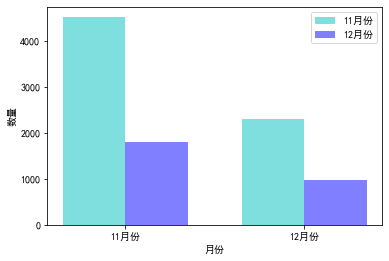

In [210]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

mpl.rcParams["font.sans-serif"]=["SimHei"]
mpl.rcParams["axes.unicode_minus"]=False

x=np.arange(2)
y=[4513,2301]
y1=[1809,979]

bar_width=0.35
tick_label=["11月份","12月份"]

plt.bar(x,y,bar_width,align="center",color="c",label="11月份", alpha=0.5)
plt.bar(x+bar_width,y1,bar_width,color="b",align="center",label="12月份", alpha=0.5)

plt.xlabel("月份")
plt.ylabel("数量")

plt.xticks(x+bar_width/2,tick_label)

plt.legend()
plt.show()

### (2)11月转评赞占比图

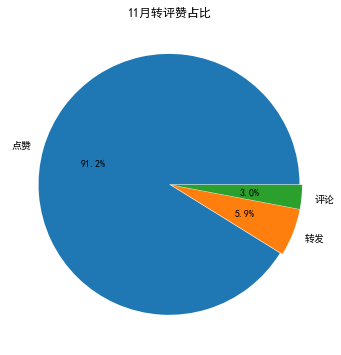

In [218]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif']='SimHei'  # 设置中文显示
plt.figure(figsize=(6,6))  # 将画布设定为正方形，则绘制的饼图是正圆

# 定义饼图的标签，标签为列表
label=['点赞','转发','评论']
# 设定各项距离圆心n个半径
explode=[0.01,0.01,0.01]
#plt.pie(values[-1,3:6],explode=explode,labels=label,autopct='%1.1f)  #绘制饼图
values=[70306,4513,2301]

plt.pie(values,explode=explode,labels=label,autopct='%1.1f%%')  #绘制饼图
plt.title('11月转评赞占比')
plt.show()

### (3)12月转评赞占比图

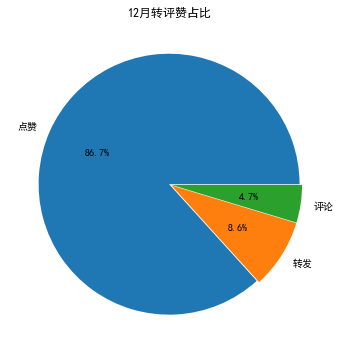

In [217]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif']='SimHei'  # 设置中文显示
plt.figure(figsize=(6,6))  # 将画布设定为正方形，则绘制的饼图是正圆

# 定义饼图的标签，标签为列表
label=['点赞','转发','评论']
# 设定各项距离圆心n个半径
explode=[0.01,0.01,0.01]
#plt.pie(values[-1,3:6],explode=explode,labels=label,autopct='%1.1f)  #绘制饼图
values=[18209,1809,979]

plt.pie(values,explode=explode,labels=label,autopct='%1.1f%%')  #绘制饼图
plt.title('12月转评赞占比')
plt.show()

### (4)传播效果柱状图

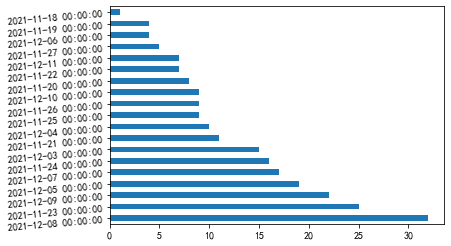

In [219]:
import pandas as pd
import matplotlib.pyplot as plt

f=pd.read_excel("D:\python作业\pythonProject\effect.xlsx",encoding="gbk")  #导入数据
# print(f.head())
f["日期"].value_counts().plot(kind="barh",rot="5")  # value_counts:数量，kind:统计数据类型，bar：柱状图，h表示横向展示,rot：label的角度
plt.show()

### (5)读取excel特定列

In [32]:
df=pd.read_excel(r"D:\python作业\pythonProject\hashtag.xlsx",usecols=[7,9,10,11])
df.to_excel(r"D:\python作业\pythonProject\effect.xlsx",index=False)

In [38]:
data=pd.read_excel(r'D:\python作业\pythonProject\effect.xlsx',encoding="utf-8")
data

,日期,点赞数,评论数,转发数
0,2021-11-23,65045,3272,1543
1,2021-12-09,7668,731,263
2,2021-12-08,2399,246,55
3,2021-12-08,2303,20,9
4,2021-11-21,1130,243,77
5,2021-12-03,1040,66,31
6,2021-11-20,940,144,53
7,2021-11-20,837,107,34
8,2021-12-05,831,16,51
9,2021-12-05,506,15,41


### (6)话题词云图

In [48]:
data=pd.read_excel(r'D:\python作业\pythonProject\title.xlsx',encoding="utf-8")
data

,正文
0,【河北沧州献县发布通告：要求全县冷链物品装卸工人进行核酸检测】12月10日，河北沧州献县新冠...
1,谁设计的？绝了#美国##聚焦新冠肺炎疫情#
2,【#满洲里公布2例确诊病例活动轨迹#：其中1人曾去过4个快递点】12月11日，内蒙古满洲里扎...
3,【#疾控专家谈成都新增4例新冠感染者#：未出现社区层面扩散 不必恐慌】12月10日，在成都市...
4,【#成都本轮疫情本土确诊升至10例# 中风险地5个】12月11日，据四川省卫健委消息，10日...
...,...
225,【#山西临猗阿根廷猪肉外包装核酸阳性# 由陕西输入】11月18日，山西运城新闻网发布消息称，...
226,【#天津新增4例本土确诊# 瞰海轩小区及相关医院被封控】11月20日凌晨，据@天津发布 消息...
227,【一个口罩得用近十次 #护士谈抗疫艰辛拜登落泪#】11月18日，拜登与几名一线医务工作者在视...
228,天津2天新增3例，对滨海新区社区的一栋楼进行全体集中隔离#聚焦新冠肺炎疫情# 健康时报记者根...


In [46]:
# 将title.xlsx文件保存为title.txt文件,使之成为jieba分词的操作对象

In [175]:
import jieba
import collections
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import chardet

In [178]:
# 读取title.txt文件
with open(r"D:\python作业\pythonProject\title.txt","r",encoding="gb18030",errors="ignore") as f:
    data=f.read()

In [179]:
# 文本预处理,去除一些无用的字符,只提取出中文出来
new_data=re.findall('[\u4e00-\u9fa5]+', data, re.S)
new_data=" ".join(new_data)

In [220]:
# 文本分词
seg_list_exact=jieba.cut(new_data,cut_all=True)
 
result_list=[]
with open(r"D:\python作业\pythonProject\stopwords.txt","r",encoding="gb18030",errors="ignore") as f:
    con=f.readlines()
    stopwords=set()
    for i in con:
        i=i.replace("\n", "")   # 去掉读取每一行数据的\n
        stopwords.add(i)
        
    for word in seg_list_exact:
        # 设置停用词并去除单个词
        if word not in stopwords and len(word)>1:
            result_list.append(word)
print(result_list)

['涓涓', '涓涓', '富浠诲', '富浠诲', '富浠诲', '富浠汇', '富浠汇', '涓涓', '涓涓', '涓涓']


In [184]:
# 筛选后统计
word_counts=collections.Counter(result_list)
# 获取前1000最高频的词
word_counts_top1000=word_counts.most_common(1000)
print(word_counts_top1000)

[('涓涓', 5), ('富浠诲', 3), ('富浠汇', 2)]


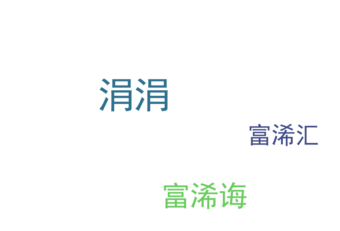

In [185]:
# 绘制词云
my_cloud=WordCloud(
    background_color='white',  # 设置背景颜色  默认是black
    width=900,height=600,
    max_words=1000,            # 词云显示的最大词语数量
    font_path='simhei.ttf',   # 设置字体  显示中文
    max_font_size=99,         # 设置字体最大值
    min_font_size=16,         # 设置子图最小值
    random_state=50           # 设置随机生成状态，即多少种配色方案
).generate_from_frequencies(word_counts)
 
# 显示生成的词云图片
plt.imshow(my_cloud,interpolation='bilinear')
# 显示设置词云图中无坐标轴
plt.axis('off')
plt.show()